## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
I start by preparing "object points". Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection, then put them into cv2.calibrateCamera() function to obtain mtx and dist

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pdb
%matplotlib qt

def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    #cv2.destroyAllWindows()

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

Text(0.5, 1.0, 'Undistorted Image')

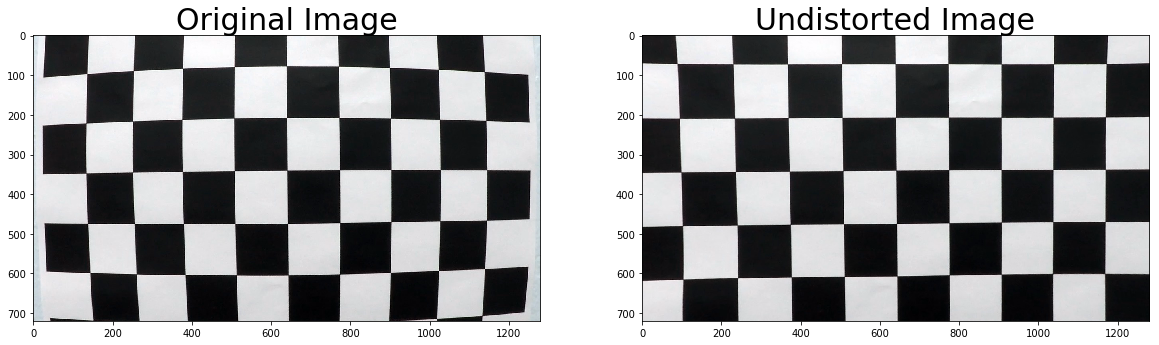

In [2]:
import pickle
import matplotlib.image as mpimg
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

mtx, dist = camera_calibration()

# Undistort image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# mpimg.imsave("output_images/undistort.jpg", dst)

Text(0.5, 1.0, 'Undistorted Image')

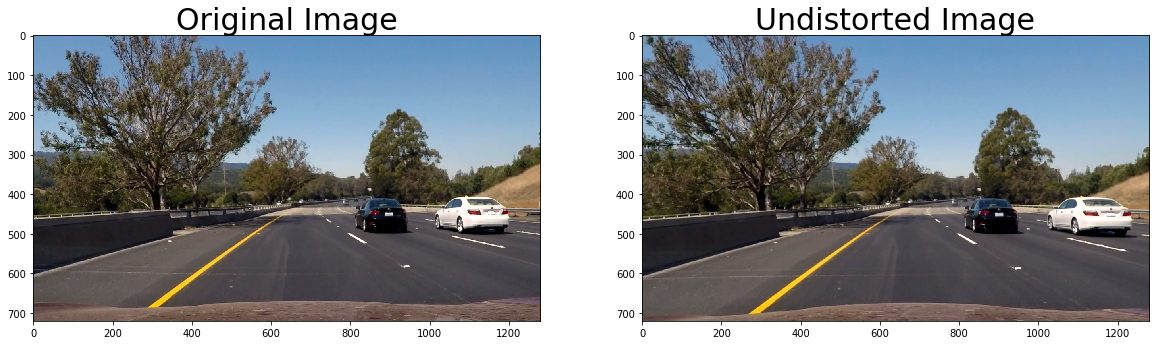

In [3]:
# Test undistortion on real world image
# Undistort image
img = mpimg.imread('test_images/test6.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# mpimg.imsave("output_images/distortion_corrected_image.jpg", dst)

## Second, I'll create a thresholded binary image
To create a thresholded binary image, I use l_channel from HLS to detect white lines and set the threshold to 200, then set the lower bound and upper bound of HSV to ([10,100,100],[30,255,255]) to detect yellow lines, and combine the two color threshold image with Sobel_x gradient.

In [4]:
# gradients functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(30, 100)):
    # Calculate directional gradient
    # Applies Sobel x or y, then takes an absolute value and applies a threshold.
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # scale the value to 0-255
    scale_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    grad_binary = np.zeros_like(scale_sobel)
    # Apply threshold
    grad_binary[(thresh[0]<scale_sobel) & (thresh[1]>scale_sobel)] = 1
    return grad_binary

Text(0.5, 1.0, 'Binary Image')

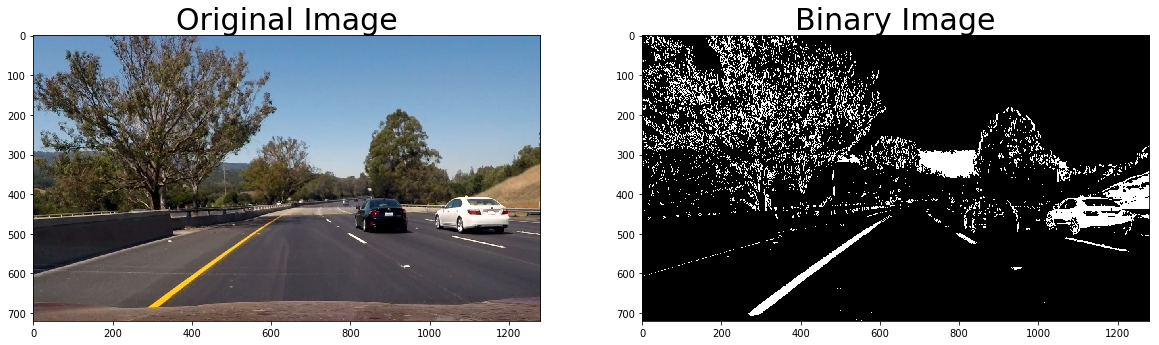

In [5]:
def binary_pipeline(image, l_thresh=200, sx_thresh=(30, 100), hsv_thresh=([10,100,100],[30,255,255])):
    # input image is a RGB undistort image    
    # A copy of original image
    img = np.copy(image)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    l_channel = hls[:,:,1]   # channel L from HLS

    # Sobel_x gradient 
    sxbinary = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=5, thresh=sx_thresh)
    
    # Threshold color channel, used to detect white lines
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 200)] = 1    
    
    # for detecting yellow lines
    lower_bound = np.array(hsv_thresh[0])
    upper_bound = np.array(hsv_thresh[1])
    hsv_binary = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # combined color threshold
    combined_color = np.zeros_like(l_binary)
    combined_color[((hsv_binary==255) | (l_binary==1))] = 1
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, combined_color)) * 255
    
    # sxbinary and color threshold combined binary
    combined = np.zeros_like(l_binary)
    #combined[(combined_color==1) | (sxbinary==1)] = 1
    combined[(color_binary[:,:,1]>0) | (color_binary[:,:,2]>0)] = 1
    
    return combined

img = mpimg.imread('test_images/test6.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary_img= binary_pipeline(undist, l_thresh=200, sx_thresh=(30, 100), hsv_thresh=([10,100,100],[30,255,255]))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
# mpimg.imsave("output_images/binary_image.jpg", binary_img, cmap="gray")

## Third, I'll perform perspective transform to binary image
 I chose the source points(src) and destination points(dst) in the following manner:

```python
src = np.float32([[211, 719], [575, 460], [710, 460], [1117,719]])
dst = np.float32([[250,gray.shape[0]], [250,0], [gray.shape[1]-330,0],
                  [gray.shape[1]-330,gray.shape[0]]])
```
And calculate the transform matrix using `cv2.getPerspectiveTransform`, then using `cv2.warpPerspective()` to warp your image to a top-down view.

Text(0.5, 1.0, 'top down view Image')

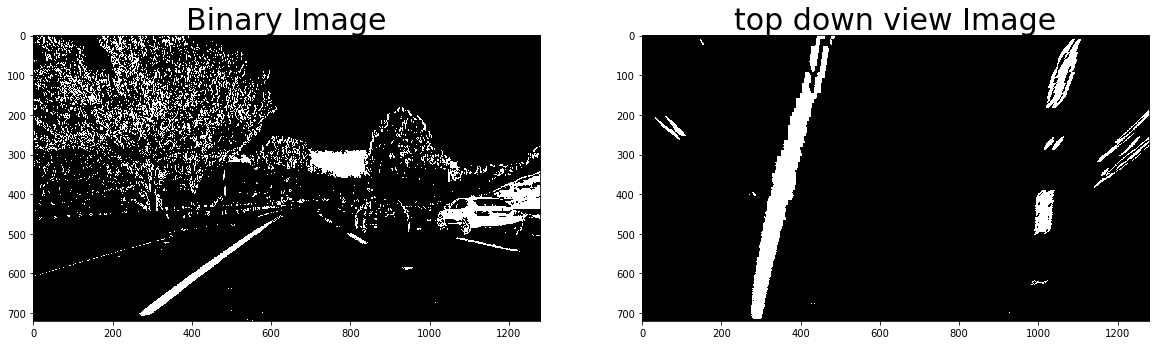

In [6]:
def perspective_transform(binary_image):
    gray = binary_image
    # Define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[211, 719], [575, 460], [710, 460], [1117,719]])
    
    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[250,gray.shape[0]], [250,0], [gray.shape[1]-330,0],
                      [gray.shape[1]-330,gray.shape[0]]])
    
    # M : transform matrix (3,3)
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform (inverse perspective transform to upwarp the image)
    # by switching the source and destination points
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(binary_image, M, (gray.shape[1], gray.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


top_down, M, Minv = perspective_transform(binary_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(binary_img, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('top down view Image', fontsize=30)

#x = [250, 250, 950, 950, 250]
#y = [719, 0, 0, 719, 719]
#plt.plot(x, y, 'r-', lw=2)
#x = [211, 575, 710, 1117]
#y = [719, 460, 460, 719]
#plt.plot(x, y, 'r-', lw=2)
#mpimg.imsave("output_images/binary_image.jpg", binary_img, cmap="gray")

## Fourth, Apply histogram to see where the lane lines are
I grab only the bottom half of the image, and adding up the pixel values along each column in the image.

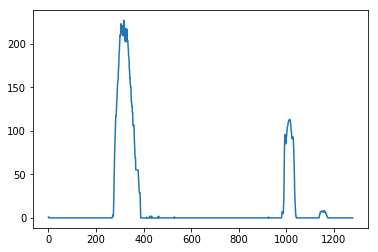

In [7]:
def hist(img):
    # Grab only the bottom half of the image
    bottom_half = np.copy(img)
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis = 0)
    return histogram

plt.plot(hist(top_down))

## Fifth, Apply sliding windows
Create sliding windows and extract pixel positions from left lane and right lane in the sliding windows, and use those pixel positions to calcutlate the coefficients of polynomial, then use the coefficients and y positions to get x positions.

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram to be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9   # Choose the number of sliding windows
    margin = 100   # Set the width of the windows +/- margin
    minpix = 50    # Set minimum number of pixels found to recenter window
    window_height = np.int(binary_warped.shape[0]//nwindows)  # Set height of windows
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()   # Return the indices(x,y position) of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1]) 
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xleft_low)\
                         & (nonzerox < win_xleft_high)).nonzero()[0]   # shape = (xxxx,)
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xright_low)\
                         & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found current window > minpix pixels, recenter next window
        if len(left_lane_inds[window]) > minpix:
            left_total_pixels = nonzerox[left_lane_inds[window]]
            leftx_current = np.int(np.mean(left_total_pixels))
        if len(right_lane_inds[window]) > minpix:
            right_total_pixels = nonzerox[right_lane_inds[window]]
            rightx_current = np.int(np.mean(right_total_pixels))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("Please check your left_lane_inds or right_lane_inds")
        pass

    # Extract left and right line pixel positions (x_array, y_array)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

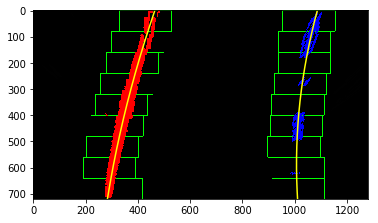

In [9]:
def fit_polynomial(binary_warped):
    '''For drawing the sliding windows and lane lines'''
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

img = mpimg.imread('test_images/test6.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
binary_img= binary_pipeline(undist, l_thresh=200, sx_thresh=(30, 100), hsv_thresh=([10,100,100],[30,255,255]))
top_down, M, Minv = perspective_transform(binary_img)
out_img = fit_polynomial(top_down)
plt.imshow(out_img)
#mpimg.imsave("output_images/out_img1.jpg", out_img)

## Sixth, Search from Prior
Use the previous polynomial to skip the sliding window step, and use the previous polynomial coefficients to search lane lines.

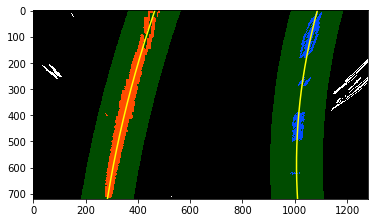

In [10]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels(top_down)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, visual=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_x = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    right_x = right_fit[0] * nonzeroy **2 + right_fit[1] * nonzeroy + right_fit[2]
    left_lane_inds = (((left_x-margin)<nonzerox) & ((left_x+margin)>nonzerox)).nonzero()[0]
    right_lane_inds = (((right_x-margin)<nonzerox) & ((right_x+margin)>nonzerox)).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    if visual == True:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        return result

    return leftx, lefty, rightx, righty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(top_down, left_fit, right_fit, visual=True)
# View your output
plt.imshow(result)

## Seventh, keep track lane lines
Use `Line()` class to keep track of all the interesting parameters I measure from frame to frame, and use `Find_line()` class to update the parameters.

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    
    def append_fitx(self, fitx):
        '''Record new parameters after sanity check'''
        if self.valid_line():
            self.detected = True
            ploty = np.linspace(0, 719, 720)
            self.current_fit = np.polyfit(ploty, fitx, 2)
            self.recent_xfitted.append(fitx)
            # keep track last 5 frames
            if len(self.recent_xfitted) > 4:
                del self.recent_xfitted[0]
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.best_fit = np.polyfit(ploty, self.bestx, 2)
        else:
            self.detected = False
            
    def valid_line(self):
        '''Do sanity check'''
        # check if the radius of curvature make sense
        if self.radius_of_curvature < 250:
            return False
        else:
            return True        
        

In [12]:
class Find_line():
    def __init__(self):
        self.left = Line()
        self.right = Line()
    
    def measure_curvature_real(self, warped, left_fitx, right_fitx, ploty):
        '''Calculates the curvature of polynomial functions in meters.'''

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720    # meters per pixel in y dimension
        xm_per_pix = 3.7/700   # meters per pixel in x dimension

        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        # Choose the maximum y-value, corresponding to the bottom of the image
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        y_eval = np.max(ploty) * ym_per_pix

        # Implement radius of curvature
        left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad 
        
    def find_lines(self, warped):
        '''Find x values for left and right lane lines''' 
        previous_left = self.left.current_fit
        previous_right = self.right.current_fit
        if not self.left.detected or not self.right.detected or previous_left.size==0 or previous_right.size==0:
            leftx, lefty, rightx, righty, _ = find_lane_pixels(warped)
        else:
            leftx, lefty, rightx, righty = search_around_poly(warped, previous_left, previous_right)

        left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
        # record radius of curvature
        left_curverad, right_curverad = self.measure_curvature_real(warped, left_fitx, right_fitx, ploty)
        self.left.radius_of_curvature = left_curverad
        self.right.radius_of_curvature = right_curverad
        
        self.left.append_fitx(left_fitx)
        self.right.append_fitx(right_fitx)
        
        # Check if the two lane lines are parallel
        distance = []
        if self.left.current_fit.size !=0 and self.right.current_fit.size!=0:
            for y in [720, 360, 0]:
                leftx = self.left.current_fit[0] * y **2 + self.left.current_fit[1] * y + self.left.current_fit[2]
                rightx = self.right.current_fit[0] * y **2 + self.right.current_fit[1] * y + self.right.current_fit[2]
                distance.append((rightx - leftx))
            if ((distance[0] - distance[1]) > 100) or ((distance[1] - distance[2]) > 100) or \
               ((distance[2] - distance[0]) > 100):
                self.left.current_fit = self.left.best_fit
                self.right.current_fit = self.right.best_fit
        
        avg_left_fitx = self.left.bestx
        avg_right_fitx = self.right.bestx
        
        return avg_left_fitx, avg_right_fitx, ploty

## Eighth, Build a Lane Finding Pipeline

In [13]:
mtx, dist = camera_calibration()
line = Find_line()

def image_pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary_img= binary_pipeline(undist, l_thresh=200, sx_thresh=(30, 100), hsv_thresh=([10,100,100],[30,255,255]))
    warped, M, Minv = perspective_transform(binary_img)   # May not need M, need to check
    left_fitx, right_fitx, ploty = line.find_lines(warped)
    #leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    #left_fitx, right_fitx, ploty = fit_poly(image.shape, leftx, lefty, rightx, righty)
    
    # Calculate curvature radius of both lines and average them
    left_curverad, right_curverad = line.measure_curvature_real(warped, left_fitx, right_fitx, ploty)  
    radius_of_curvature = int((left_curverad + right_curverad)/2)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate center of the road to the center of the image
    left_x = left_fitx[-1]       # left line x position at bottom of image
    right_x = right_fitx[-1]     # right line x position at bottom of image
    offset = (1280/2) - (left_x + right_x)/2
    offset_direction = "right" if offset > 0 else "left"
    offset_meter = abs(offset * 3.7/700)
    
    # write radius and offset onto image
    result = cv2.putText(result, "Radius of Curvature = " + str(radius_of_curvature) + "(m)", 
             (70, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    result = cv2.putText(result, 'Vehicle is %.2fm %s of center' %(offset_meter,offset_direction),
             (70, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255),3)
    
    return result

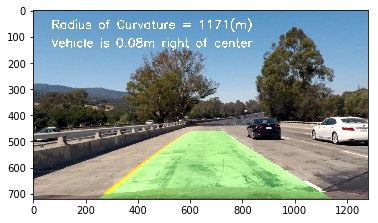

In [14]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image_pipeline(image))
mpimg.imsave("output_images/result.jpg", image_pipeline(image))

# Test on Videos

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
# run image pipeline with video
output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(image_pipeline)  #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:20<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 4min 21s


In [17]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))